In [7]:
# Importação das bibliotecas necessárias
import imutils
import cv2
from matplotlib import pyplot as plt
from transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np

In [50]:
# Definindo uma função para exibição das imagens
def show_image_in_window(title, image):
    
    # Exibe a imagem captura anteriormente
    cv2.imshow(title, image)
    
    # Aperte alguma tecla para liberar o processamento
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def show_image_in_jupyter(title, image):    
    plt.figure(figsize=(6, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), aspect='auto')
    plt.title(title)
    plt.tight_layout()    

### Introdução

Neste notebook será criado um scanner de documentos. São necessárias 3 etapas para a construção deste scanner:
- Detectar bordas
- Usar as bordas na imagem para encontrar os contornos representando o papel a ser escaneado
- Aplicar uma transformação de perspectiva para obter uma visão de cima a baixo (top-down) do documeento

In [157]:
# imagem a ser utilizada
image_path = 'receipt.jpg'

#### Etapa 1 - Detecção da borda

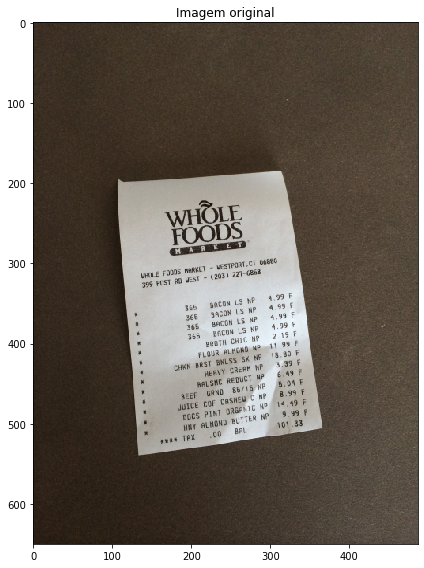

In [158]:
# Carrega a imagem e computa a proporção da 
# altura antiga para a nova altura, clona e 
image = cv2.imread(image_path)
ratio = image.shape[0]/500.0
orig = image.copy()
show_image_in_jupyter("Imagem original", imutils.resize(orig, height = 650))
show_image_in_window("Imagem original", imutils.resize(orig, height = 650))

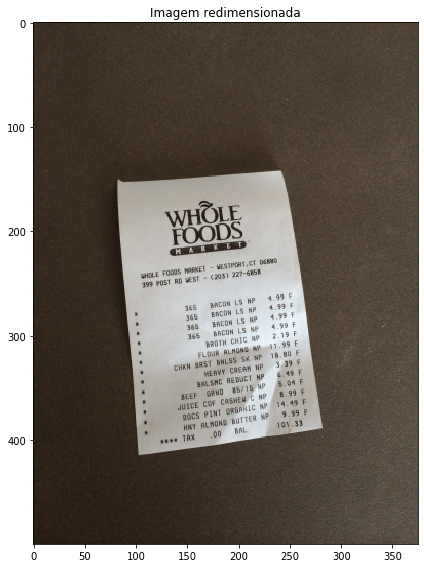

In [159]:
# redimensiona
image = imutils.resize(image, height=500)
show_image_in_jupyter("Imagem redimensionada", image)
show_image_in_window("Imagem redimensionada", image)

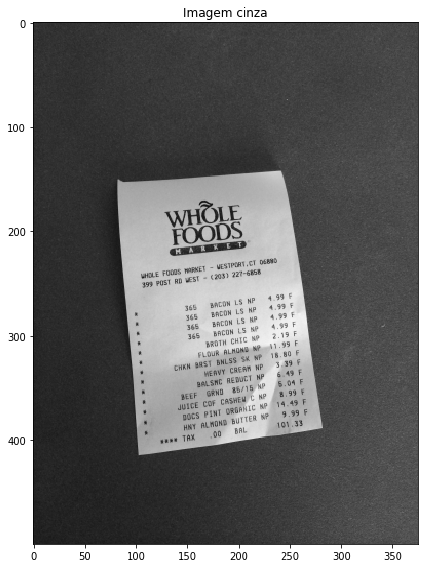

In [160]:
# Converte a imagem para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image_in_jupyter("Imagem cinza", gray)
show_image_in_window("Imagem cinza", gray)

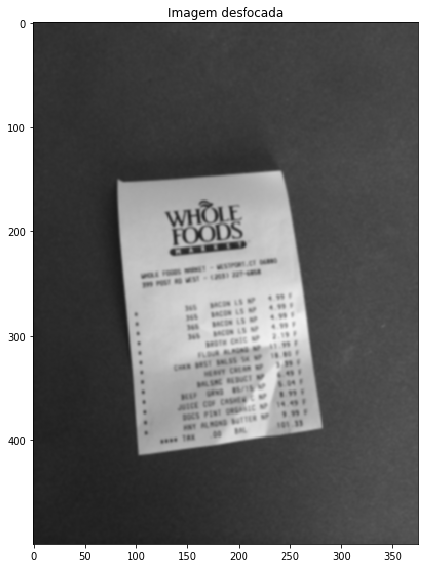

In [161]:
# Desfoca a imagem
gray = cv2.GaussianBlur(gray, (5,5), 0)
show_image_in_jupyter("Imagem desfocada", gray)
show_image_in_window("Imagem desfocada", gray)

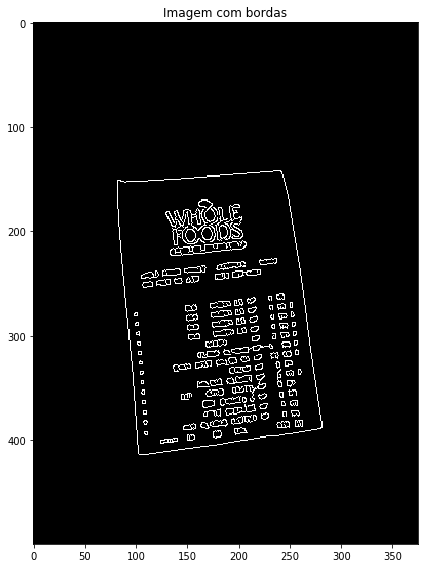

In [162]:
# Procura as bordas
edged = cv2.Canny(gray, 75, 200)
show_image_in_jupyter("Imagem com bordas", edged)
show_image_in_window("Imagem com bordas", edged)

#### Etapa 2 - Encontrando contornos

In [163]:
# Encontra os contornos da borda da image, 
# mantém apenas os maiores e inicializa o contorno
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

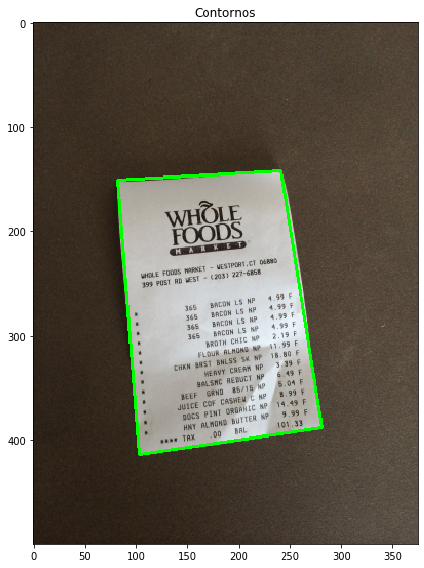

In [164]:
# Itera pelos contornos
for c in cnts:
    
    # Contorno aproximado
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    # Se o contorno aproximado tiver 4 pontos, 
    # então assumimos que encontramos os cotornos corretos da tela
    if len(approx) == 4:
        screenCtn = approx
        break
        
# Exibe o contorno do papel
cv2.drawContours(image, [screenCtn], -1, (0, 255, 0), 2)
show_image_in_jupyter("Contornos", image)
show_image_in_window("Contornos", image)

#### Etapa 3 - Aplicar transformação de perspectiva

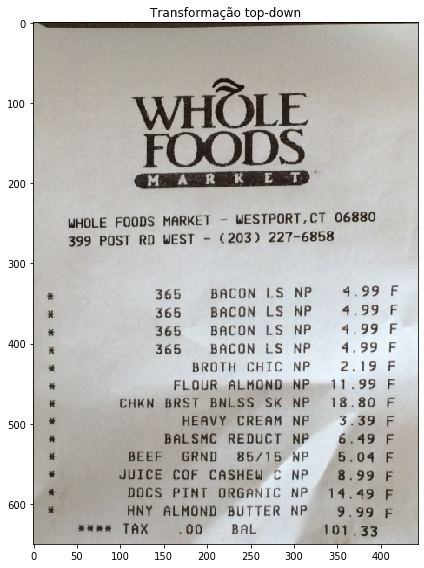

In [165]:
# Aplica a transformação para obter a visão "top-down" do documento
warped = four_point_transform(orig, screenCtn.reshape(4, 2) * ratio)
show_image_in_jupyter("Transformação top-down", imutils.resize(warped, height = 650))
show_image_in_window("Transformação top-down", imutils.resize(warped, height = 650))

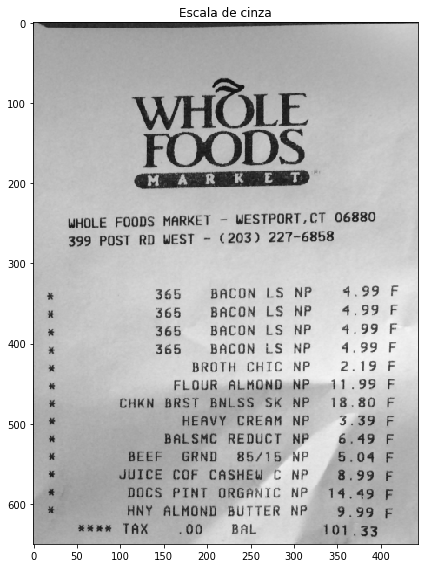

In [166]:
# Converte para escala de cinza
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
show_image_in_jupyter("Escala de cinza", imutils.resize(warped, height = 650))
show_image_in_window("Escala de cinza", imutils.resize(warped, height = 650))

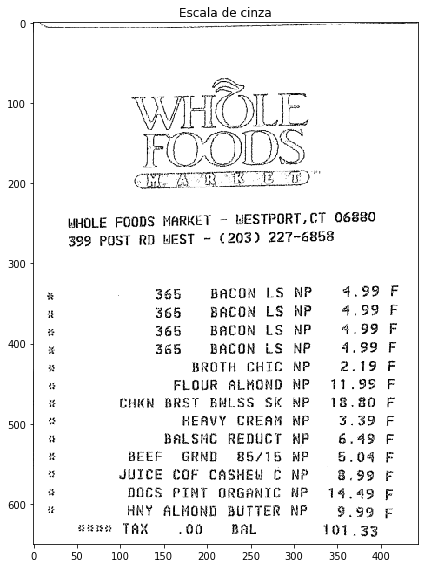

In [167]:
# Aplica o limiar para obter o efeito branco e preto
T = threshold_local(warped, 11, offset = 10, method = 'gaussian')

warped = (warped > T).astype("uint8") * 255
show_image_in_jupyter("Escala de cinza", imutils.resize(warped, height = 650))
show_image_in_window("Escala de cinza", imutils.resize(warped, height = 650))